# GridSearchCV for LightGBM in R

## Quick Infos on LightGBM
- Microsoft's open source implementation of gradient boosting machines
- Faster than xgboost for large data sets thanks to fast histogram mode
- Results tends to be more accurate than those of xgboost thanks to different split strategy.
- Written in C++ with bindings for Python and R
- Binding for Python and R available. R package still relatively difficult to install and not extremely stable. Expect some hard crashes ;).
- GPU support for even faster training

Check out details on (https://github.com/Microsoft/LightGBM).

## GridSearchCV
With gradient boosting machines (GBM), there are multiple parameters to tune, all with considerable impact on performance. How do you choose them without too much manual work and without too much overfit? 

One of the most used ways is a technique called "GridSearchCV". It is very simple and can be applied basically for all modelling techniques, even for multiple linear regression (e.g. to choose covariables, interactions etc.). Exceptions are deep neural networks that are just too computer intensive for cross-validation.


GridSearchCV works as follows: 

For relevant parameters, different values are specified. Then, the model is trained once for each parameter combination. If the number of combinations it too large or not all combinations make any sense, then pick only a subset of all combinations. To avoid overfitting, the performance (e.g. root mean squared error RMSE for regression) is obtained through cross-validation. 

In the end, the final model is trained on the best choice of parameters. It is also popular to pick the best few choices of parameters, run multiple final models and combine their predictions. Why? If you take a couple of unbiased models and combine their predictions, you will end up with an unbiased model, but with slightly smaller variance.  

## Purpose of this R notebook
While already available in Python's sklearn, there is (as far as I can say) not much R code around to show how to implement GridSearchCV for LightGBM. There are code snippets around for grid search, but without CV, which is a major element.

We use a nice data set with around 50'000 diamonds and try to predict the selling price based on its properties.

## Let's load the Packages

In [1]:
library(ggplot2)  # for diamonds data
library(lightgbm) # our main library
library(glmnet)   # just for fun

Loading required package: R6
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13



## Then the Data...
The data set contains around 50k lines and variables like price, carat, cut, clarity and clarity (the fifth "c" (certificate) is missing...) and shape. 

[1] 53940

carat,cut,color,clarity,depth,table,price,x,y,z,log_price,log_carat
0.23,5,2,2,61.5,55,326,3.95,3.98,2.43,5.786897,-1.469676
0.21,4,2,3,59.8,61,326,3.89,3.84,2.31,5.786897,-1.560648
0.23,2,2,5,56.9,65,327,4.05,4.07,2.31,5.789960,-1.469676
0.29,4,6,4,62.4,58,334,4.20,4.23,2.63,5.811141,-1.237874
0.31,2,7,2,63.3,58,335,4.34,4.35,2.75,5.814131,-1.171183
0.24,3,7,6,62.8,57,336,3.94,3.96,2.48,5.817111,-1.427116


     carat             cut            color          clarity     
 Min.   :0.2000   Min.   :1.000   Min.   :1.000   Min.   :1.000  
 1st Qu.:0.4000   1st Qu.:3.000   1st Qu.:2.000   1st Qu.:3.000  
 Median :0.7000   Median :4.000   Median :4.000   Median :4.000  
 Mean   :0.7979   Mean   :3.904   Mean   :3.594   Mean   :4.051  
 3rd Qu.:1.0400   3rd Qu.:5.000   3rd Qu.:5.000   3rd Qu.:5.000  
 Max.   :5.0100   Max.   :5.000   Max.   :7.000   Max.   :8.000  
     depth           table           price             x         
 Min.   :43.00   Min.   :43.00   Min.   :  326   Min.   : 0.000  
 1st Qu.:61.00   1st Qu.:56.00   1st Qu.:  950   1st Qu.: 4.710  
 Median :61.80   Median :57.00   Median : 2401   Median : 5.700  
 Mean   :61.75   Mean   :57.46   Mean   : 3933   Mean   : 5.731  
 3rd Qu.:62.50   3rd Qu.:59.00   3rd Qu.: 5324   3rd Qu.: 6.540  
 Max.   :79.00   Max.   :95.00   Max.   :18823   Max.   :10.740  
       y                z            log_price       log_carat       
 Min. 

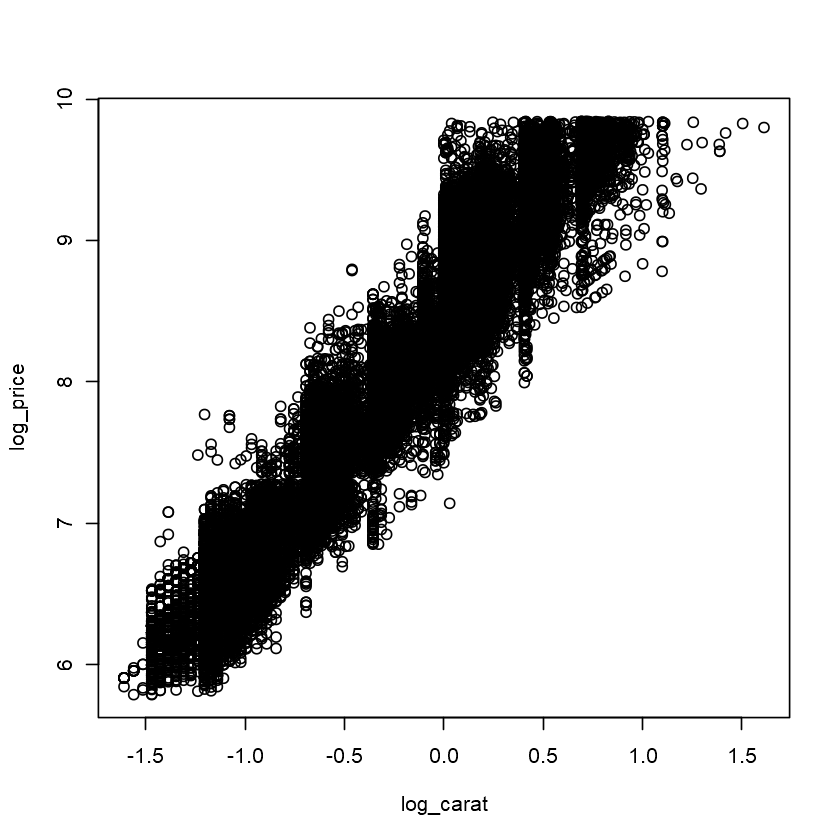

In [13]:
nrow(diamonds)
head(diamonds)

# data preparation
diamonds <- transform(as.data.frame(diamonds),
                      log_price = log(price),
                      log_carat = log(carat),
                      cut = as.numeric(cut),
                      color = as.numeric(color),
                      clarity = as.numeric(clarity))
summary(diamonds)

plot(log_price ~ log_carat, data = diamonds)


As usual we make a train/test split. No need for validation set today since we use cross validation. 



In [8]:
# Input used
x <- c("log_carat", "cut", "color", "clarity", "depth", "table")

# Train/test split
set.seed(3928272)
.in <- sample(c(FALSE, TRUE), 
              nrow(diamonds), 
              replace = TRUE, 
              p = c(0.15, 0.85))

train <- list(X = as.matrix(diamonds[.in, x]),
              y = as.numeric(diamonds[.in, "log_price"]))

test <- list(X = as.matrix(diamonds[!.in, x]),
             y = as.numeric(diamonds[!.in, "log_price"]))

# small helper function
rmse <- function(y, pred) {
  sqrt(mean((y - pred)^2))
}

## Benchmark 1: Multiple Linear Regression
Since the relationship between carat and price is strong (and quite linear on the log scale), we expect a multiple linear regression (without any fuzz like interactions, non-linearities etc.) to perform relatively well. To not always take the classic `lm` function, we work with `glmnet`, a high performance implementation of regularized GLMs. But today, we just use it to fit a linear regression.

In [9]:
fit_lm <- glmnet(train$X, y = train$y, lambda = 0)
rmse(test$y, predict(fit_lm, test$X)) # 0.1455686 on the test data set


[1] 0.1455686

Okay, not bad. In the hold-out data set, we are 14.5% off the right price *on average*. How good is a gradient booster with default parameters?

## Benchmark 2: Untuned Gradient Boosting with LightGBM
So let's fit a first, very simple model with LightGBM.

In [11]:
dtrain <- lgb.Dataset(train$X, 
                      label = train$y)

params <- list(learning_rate = 0.1)

system.time(fit_lgb <- lgb.train(params = params,
                                 data = dtrain,
                                 nrounds = 200,
                                 objective = "regression",
                                 verbose = 0L)) # 0.8 seconds

pred <- predict(fit_lgb, test$X)
rmse(test$y, pred) # 0.09566155

   user  system elapsed 
   3.88    1.95    1.02 

[1] 0.09566155

Wow. Much better performance than our multiple linear model. And check out the elapsed time: Just one second for growing 200 trees on 40'000 lines. This is fantastic. 

Remainder: We are actually not allowed to compare those performances on the hold-out data set in order to take a *decision*. But since our intention/decision is anyway to go for gradient boosting with GridSearchCV, let's close two eyes here.

## LightGBM with CV
Before we move on to the ultimate goal, let's have a quick look how to do cross-validation with LightGBM:

In [14]:
system.time(fit_lgb2 <- lgb.cv(params = params,
                               data = dtrain,
                               nrounds = 1000, # we use early stopping anyway
                               nfold = 5,
                               objective = "regression",
                               eval = "rmse",
                               showsd = FALSE,
                               early_stopping_rounds = 5,
                               verbose = 0L))
info <- as.list(fit_lgb2)
info$best_iter
-info$best_score # interestingly, LightGBM flips sign so that high values are good. 

   user  system elapsed 
  21.74    7.47    4.37 

[1] 300

[1] 0.09676132

We ran five-fold cross validation and decided to stop early as soon as the cross-validation performance (rmse) starts to get worse. In above example, it happens after around 300 rounds of boosting and the cross-validation performance is around 9.68%. This time we do not peek at the hold-out set...

## GridSearchCV with LightGBM
Let's search for optimal parameters to run LightGBM on this data set. To do so, we select standard ranges for the relevant parameters and store all combinations in a data.frame. Note that we don't have many covariables, so no need to use regularization. Our grid has 108 combinations. It also contains fixed parameters. They do not hurt.

We also add two columns "iteration" and "score" that will store the key results of the cross-validation. Iteration is the "optimal" stopping ground, i.e. when the cross-validated score starts to get worse again.

In [18]:
paramGrid <- expand.grid(iteration = NA_integer_, # filled by algorithm
                         score = NA_real_,     # "
                         learning_rate = c(0.1, 0.05, 0.01),
                         num_leaves = 2^(5:7) - 1,
                         min_data_in_leaf = c(20, 40),
                         feature_fraction = c(0.8, 1),
                         bagging_fraction = c(0.6, 0.8, 1),
                         bagging_freq = 4,
                         nthread = 4)

(n <- nrow(paramGrid)) # 108

head(paramGrid)

[1] 108

iteration,score,learning_rate,num_leaves,min_data_in_leaf,feature_fraction,bagging_fraction,bagging_freq,nthread
NA,NA,0.10,31,20,0.8,0.6,4,4
NA,NA,0.05,31,20,0.8,0.6,4,4
NA,NA,0.01,31,20,0.8,0.6,4,4
NA,NA,0.10,63,20,0.8,0.6,4,4
NA,NA,0.05,63,20,0.8,0.6,4,4
NA,NA,0.01,63,20,0.8,0.6,4,4


The first model to be trained will use a learning rate of 0.1 etc.

Now, we go through this table row by row and fit the corresponding model by CV. This might take around 10-15 minutes - grab a coffee or a beer, depending on the time...

In [19]:
for (i in seq_len(n)) {
  print(i)
  gc(verbose = FALSE) # clean memory

  cvm <- lgb.cv(as.list(paramGrid[i, -(1:2)]), 
                dtrain,     
                nrounds = 1000, # we use early stopping
                nfold = 5,
                objective = "regression",
                showsd = FALSE,
                early_stopping_rounds = 5,
                verbose = 0L)
  
  paramGrid[i, 1:2] <- as.list(cvm)[c("best_iter", "best_score")]
  save(paramGrid, file = "paramGrid.RData") # if lgb crashes
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108


Uff, that was some hard work. But imagine how many beers it would have taken us with a slower implementation of GBM! 

The next step is to investigate the best choices of parameters and refit one or more models based on these.

In [22]:
# load("paramGrid.RData", verbose = TRUE)
head(paramGrid <- paramGrid[order(-paramGrid$score), ])

,iteration,score,learning_rate,num_leaves,min_data_in_leaf,feature_fraction,bagging_fraction,bagging_freq,nthread
99,827,-0.009270935,0.01,127,20,1,1.0,4,4
98,163,-0.009276127,0.05,127,20,1,1.0,4,4
63,756,-0.009281595,0.01,127,20,1,0.8,4,4
95,285,-0.009299316,0.05,63,20,1,1.0,4,4
92,623,-0.009314967,0.05,31,20,1,1.0,4,4
62,146,-0.009317849,0.05,127,20,1,0.8,4,4


For instance we can spot that learning rates of 0.01 or 0.05 are better than 0.1. No need to worry about the negative RMSE: LightGBM seems to flip signs so that higher values are better.

Now let's get predictions for the best three models and average them. What root mean squared error on the hold-out data set do we get using this technique?

In [23]:
# Use best m
m <- 3

# keep test predictions, no model
predList <- vector(mode = "list", length = m)

for (i in seq_len(m)) {
  print(i)
  gc(verbose = FALSE) # clean memory
  
  fit_temp <- lgb.train(paramGrid[i, -(1:2)], 
                        data = dtrain, 
                        nrounds = paramGrid[i, "iteration"],
                        objective = "regression",
                        verbose = 0L)
  
  predList[[i]] <- predict(fit_temp, test$X)
}

pred <- rowMeans(do.call(cbind, predList))
rmse(test$y, pred) # 0.09437292

[1] 1
[1] 2
[1] 3


[1] 0.09438452

That is the power of GridSearchCV... the hold-out performance is clearly better than with quite default settings. On average, our predicions are off by 9.4%.

## Summary
GridSearchCV plus fast implementations of gradient boosting like LightGBM or XGBoost is an excellent combo. Actually, it is the standard way to work on kaggle competitions. There, you can't do bad if you invest a lot of time in understanding the data, prepare it and then do something like this here.